# Part1:

In [1]:
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import ParameterGrid
from models import SARSA,QLearning,ExpectedSARSA
from tqdm import tqdm
import pandas as pd
import numpy as np
from gym.spaces.prng import seed
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_experiment(agent,description=""):
    SEGMENTS = 100
    TRAIN_EPISODES = 10
    TEST_EPISODES = 1
    RUNS = 10
    
    train_scores = []
    test_scores = []
    pbar = tqdm(range(RUNS))
    
    for run in pbar:
        agent.reset()
        for segment in range(SEGMENTS):
            pbar.set_description(f"SEGMENT {segment:2d} | "+description)
            train_scores.append(agent.run(n_episodes=TRAIN_EPISODES,verbose=0))
            test_scores.append(agent.run(n_episodes=TEST_EPISODES,mode="test",verbose=0,render=False))
    
    train_scores = np.array(train_scores).reshape(RUNS,SEGMENTS,TRAIN_EPISODES)
    test_scores = np.array(test_scores).reshape(RUNS,SEGMENTS,TEST_EPISODES)
    return train_scores,test_scores


In [3]:
def run_grid_search(algorithm,grid,n_seed=42):
    parameters = ParameterGrid(grid)
    history = []
    results_df = pd.DataFrame(columns=["init_temperature","alpha","avg_reward_train","avg_reward_test"])
    print(f"The grid contains {len(parameters)} rows")
    for param in parameters:
        agent = algorithm('Taxi-v2',
                    exploration="softmax",
                    init_temperature=param["init_temperature"],
                    decay=1, 
                    alpha=param["alpha"], 
                    gamma=.9
        )

        description = "training with params:"+" - ".join(map(lambda x:f"{x[0]}={x[1]:1.2f}",param.items()))
        train_scores,test_scores = run_experiment(agent,description = description)
        history.append((train_scores,test_scores))

        avg_reward_test  = test_scores[:,-1,:].mean()
        avg_reward_train = train_scores[:,-1,:].mean()
        results_df = results_df.append(pd.DataFrame([{'alpha': param["alpha"], 
                                                      'init_temperature': param["init_temperature"],
                                                      'avg_reward_train':avg_reward_train,
                                                      'avg_reward_test':avg_reward_test}]),sort=True,ignore_index=True)
    
    return history, results_df


In [4]:
def plot_parameter_influence(grid_results):
    plt.rcParams['figure.figsize'] = 15, 5
    
    # Plot Testing results
    ax = plt.subplot(1,2,2)
    for init_temperature in grid_results["init_temperature"].unique():
        grid_results.loc[grid_results["init_temperature"]==init_temperature].plot(x="alpha",y="avg_reward_test",ax=ax,marker="o", linestyle='dashed',label=f"Temperature = {init_temperature}")
    for i,row in grid_results.iterrows():
        ax.annotate(i, (row["alpha"], row["avg_reward_test"]),xytext=(5,10),textcoords='offset points')
        
    plt.ylabel("Final Reward")
    plt.xlabel("Learning Rate")
    plt.title("Parameters influence on the final reward - Testing")
    
    # Plot Training results
    ax = plt.subplot(1,2,1)
    for init_temperature in grid_results["init_temperature"].unique():
        grid_results.loc[grid_results["init_temperature"]==init_temperature].plot(x="alpha",y="avg_reward_train",ax=ax,marker="o", linestyle='dashed',label=f"Temperature = {init_temperature}")
    
    for i,row in grid_results.iterrows():
        ax.annotate(i, (row["alpha"], row["avg_reward_train"]),xytext=(5,10),textcoords='offset points')
    plt.ylabel("Final Reward")
    plt.xlabel("Learning Rate")
    plt.title("Parameters influence on the final reward - Training")

    plt.show()
    
def plot_learning_curves(history,best_idx):
    plt.rcParams['figure.figsize'] = 15, 10
    train_arr,test_arr = history[best_idx]
    
    # Plot Learning curves
    plt.subplot(2,2,1)
    plt.plot(train_arr.mean((0,2)).reshape(-1,1))
    plt.title("Learning curve - mean - training")
    plt.xlabel("Training segments")
    plt.ylabel("Averaged Reward")
    
    plt.subplot(2,2,2)
    plt.plot(train_arr.std((0,2)).reshape(-1,1))
    plt.title("Learning curve - std - training")
    plt.ylabel("Standard Deviation of Reward")
    plt.xlabel("Training segments")
    
    plt.subplot(2,2,3)
    plt.plot(test_arr.mean(0))
    plt.title("Learning curve - mean - testing")
    plt.ylabel("Averaged Reward")
    plt.xlabel("Testing segments")
    
    plt.subplot(2,2,4)
    plt.plot(test_arr.std(0))
    plt.title("Learning curve - std - testing")
    plt.ylabel("Standard Deviation of Reward")
    plt.xlabel("Testing segments")

    plt.show()


In [5]:
grid = {
    "init_temperature":[.1, 1, 10],
    "alpha":[.1,0.5,.9]
}


## Sarsa

In [18]:
sarsa_history, sarsa_results_df = run_grid_search(SARSA,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT  0 | training with params:alpha=0.10 - init_temperature=0.10:   0%|          | 0/10 [00:00<?, ?it/s]

The grid contains 9 rows


SEGMENT 99 | training with params:alpha=0.10 - init_temperature=0.10: 100%|██████████| 10/10 [01:36<00:00,  9.66s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=1.00: 100%|██████████| 10/10 [02:17<00:00, 13.76s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=10.00: 100%|██████████| 10/10 [02:55<00:00, 17.55s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=0.10: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=1.00: 100%|██████████| 10/10 [00:42<00:00,  4.24s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=10.00: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=0.10: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=1.00: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_te

In [19]:
sarsa_results_df

,alpha,avg_reward_test,avg_reward_train,init_temperature
0,0.1,-75.0,-2.36,0.1
1,0.1,-74.3,-53.98,1.0
2,0.1,-157.4,-440.72,10.0
3,0.5,8.4,7.65,0.1
4,0.5,8.0,8.18,1.0
5,0.5,8.3,2.80,10.0
6,0.9,-12.6,8.24,0.1
7,0.9,-13.5,7.11,1.0
8,0.9,-12.8,6.49,10.0


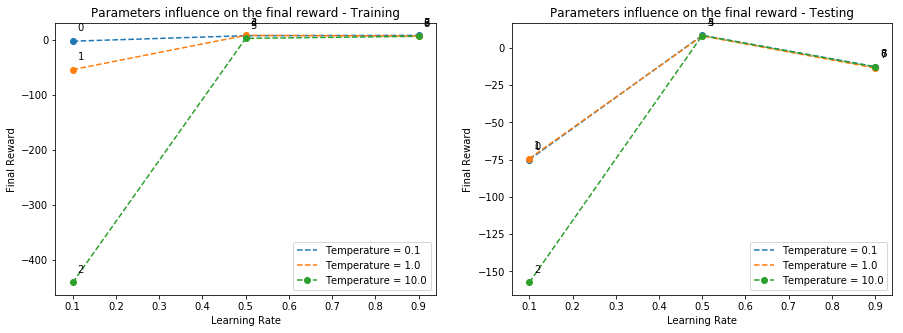

In [20]:
plot_parameter_influence(sarsa_results_df)

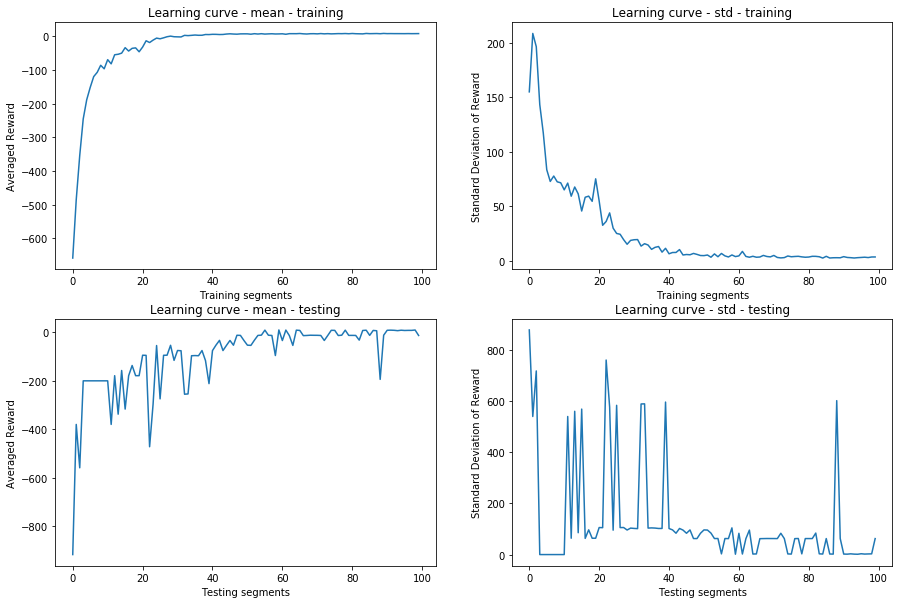

In [9]:
plot_learning_curves(sarsa_history,best_idx=3)

## QLearning

In [10]:
q_history, q_results_df = run_grid_search(QLearning,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT  0 | training with params:alpha=0.10 - init_temperature=0.10:   0%|          | 0/10 [00:00<?, ?it/s]

The grid contains 9 rows


SEGMENT 99 | training with params:alpha=0.10 - init_temperature=0.10: 100%|██████████| 10/10 [01:36<00:00,  9.64s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=1.00: 100%|██████████| 10/10 [02:11<00:00, 13.11s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=10.00: 100%|██████████| 10/10 [03:21<00:00, 20.14s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=0.10: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=1.00: 100%|██████████| 10/10 [00:43<00:00,  4.33s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=10.00: 100%|██████████| 10/10 [01:21<00:00,  8.20s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=0.10: 100%|██████████| 10/10 [00:29<00:00,  2.99s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=1.00: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_te

In [11]:
q_results_df

,alpha,avg_reward_test,avg_reward_train,init_temperature
0,0.1,-95.5,-0.74,0.1
1,0.1,-73.8,-20.87,1.0
2,0.1,-32.9,-370.98,10.0
3,0.5,-12.5,8.35,0.1
4,0.5,7.2,8.31,1.0
5,0.5,9.0,2.75,10.0
6,0.9,-12.5,8.00,0.1
7,0.9,6.8,7.71,1.0
8,0.9,7.2,2.90,10.0


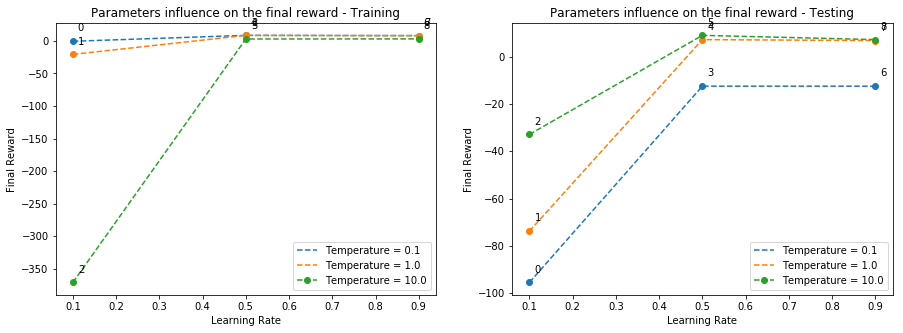

In [12]:
plot_parameter_influence(q_results_df)

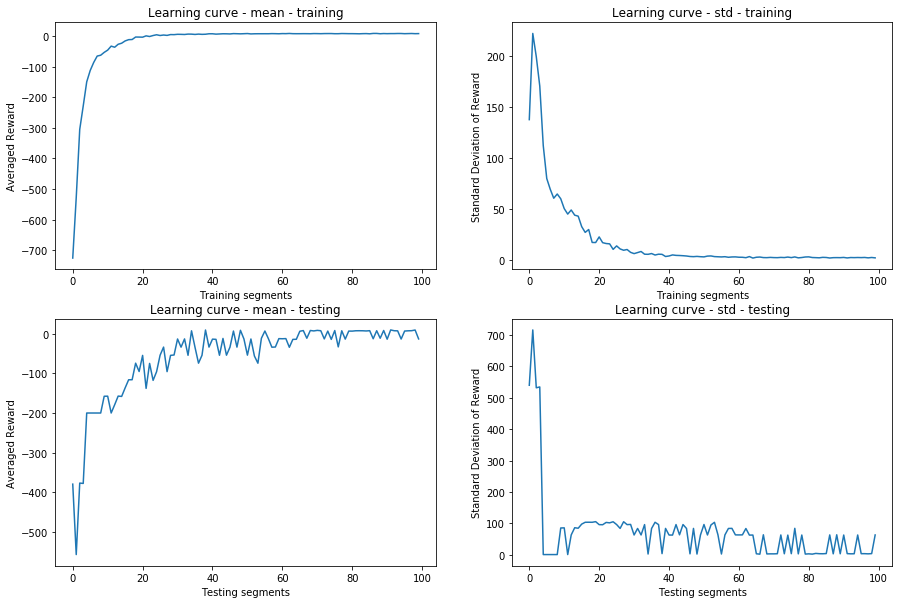

In [13]:
plot_learning_curves(q_history,best_idx=6)

## ExpectedSARSA

In [14]:
exsarsa_history, exsarsa_results_df = run_grid_search(ExpectedSARSA,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT  0 | training with params:alpha=0.10 - init_temperature=0.10:   0%|          | 0/10 [00:00<?, ?it/s]

The grid contains 9 rows


SEGMENT 99 | training with params:alpha=0.10 - init_temperature=0.10: 100%|██████████| 10/10 [01:58<00:00, 11.81s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=1.00: 100%|██████████| 10/10 [03:00<00:00, 18.00s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=10.00: 100%|██████████| 10/10 [04:14<00:00, 25.49s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=0.10: 100%|██████████| 10/10 [00:53<00:00,  5.30s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=1.00: 100%|██████████| 10/10 [01:01<00:00,  6.19s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=10.00: 100%|██████████| 10/10 [01:58<00:00, 11.84s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=0.10: 100%|██████████| 10/10 [00:42<00:00,  4.22s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=1.00: 100%|██████████| 10/10 [00:49<00:00,  4.95s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_te

In [15]:
exsarsa_results_df

,alpha,avg_reward_test,avg_reward_train,init_temperature
0,0.1,-95.0,-2.82,0.1
1,0.1,-73.6,-44.99,1.0
2,0.1,-136.2,-404.87,10.0
3,0.5,8.5,8.16,0.1
4,0.5,7.9,7.45,1.0
5,0.5,8.3,5.75,10.0
6,0.9,7.4,8.21,0.1
7,0.9,6.4,7.60,1.0
8,0.9,7.8,3.94,10.0


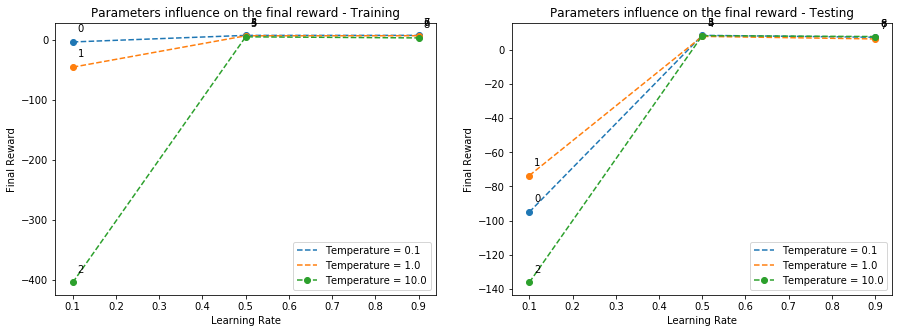

In [16]:
plot_parameter_influence(exsarsa_results_df)

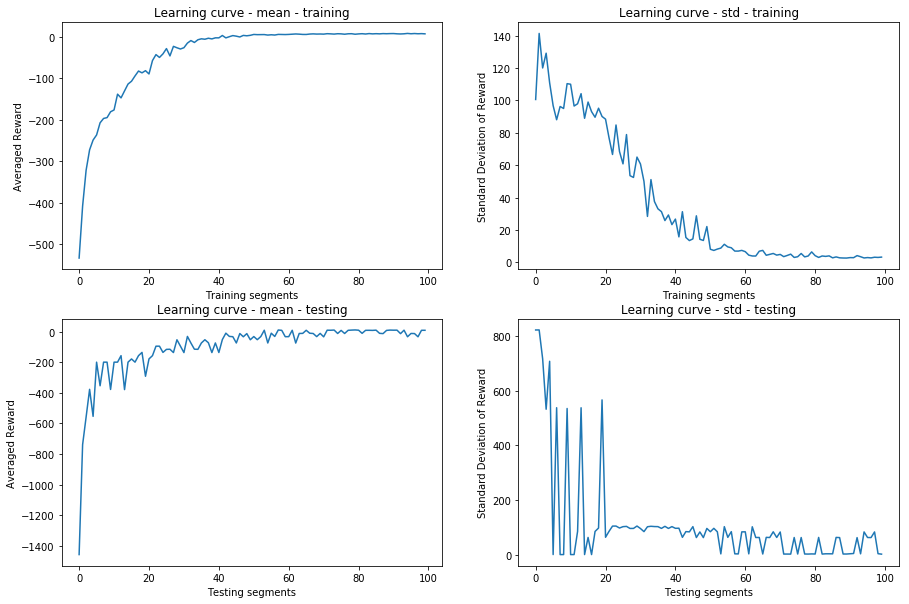

In [17]:
plot_learning_curves(exsarsa_history,best_idx=4)

**Discussion:**

In this part of the assignment, we performed some experiments with three algorithms on the Taxi-v2 OpenAI gym. For each experiment we pick a temperature value and a learning rate and run the three algorithms in 100 segments, each composed of 10 episodes for training and another one for testing where we run the greedy policy we learned so far.

we have chosen three temperature values with a factor of 10 to transition from a temperature to the next one. we picked 0.1, 1 and 10 for these experiments. 

We wanted to cover the whole range of possible values for learning rate, but since we only have to pick 3 values we have chosen the midpoint of the range and two other learning rates with the same distance from the bounds of the range. The values we considered are: \[0.1, 0.5, 0.9\]

From influence graphs, we notice that the experiments with the highest temperature value of 10 and a learning rate of 0.1 tends to be the worst at training with a large gap compared to the two other temperature values. However, the gap is comparable at testing. It is even the highest for the *Q-Learning* algorithm. Once we have a sufficiently high learning rate, the experiments with the highest temperature value slightly outperformed all the others for the three algorithms on testing but still slightly worst compared the two others on training.

This impact of the temperature can be explained with the following analysis:

Suppose we have *d* actions. Let $q\in \mathbb R^d$ be the vector denoting the action-value function taken at a state $s$ and $S_i(q) = \exp(q_i) / \sum_j\exp(q_j)$ be the probability of picking the $ith$ action while exploring given by the boltzman distribution. Let $A_t(q) = S(\frac{q}{t}) = \exp(\frac{q_i}{t}) / \sum_j\exp(\frac{q_j}{t})$ where t is a positive real number. We notice that when t is pushed towards infinity we get $\lim_{t \rightarrow \infty} S_i(\frac{q}{t}) = 1 / d$. That is we have equal probabilities for all actions, thus the higher the constance t is, the more our algorithm is favoring exploration against the greedy behavior leading to a poor behaviour in training. However when t is heading toward zero we can prove that $\lim_{t \rightarrow 0} S_i(\frac{q}{t}) = \mathbb 1_{q_i = \max_{j}(q_j)} / \ell$ where $\ell$ is the number of actions with the same highest q-value. Therefore, if we suppose that there is only one best action $i$ (with respect to the currect q-value) than the probability of taking that action is $\lim_{t \rightarrow 0} S_i(\frac{q}{t}) = 1$ and it's a zero probability for non-greedy actions. In this case, with low values of t we tend to be favoring the greedy behavior and thus exploiting what have already learned instead of exploring new actions.

The advantage of the boltzman distribution is that it mimics the $\epsilon$-gready behaviour but with two other interesting advantages: 

- It is giving us the control of how much exploring we wants our agent to do throught the parameter t, the higher t is the more we get closer to a pure $\epsilon$-greedy algorithm.

- It gives weighted chances for actions to be considered: sub-optimal actions have higher chances to be selected instead of selected among all the actions with an equal probability.